In [28]:
#libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from duckdb import query as qr
import imaplib
import email
import os
from datetime import datetime
import zipfile
import io
from email.utils import parseaddr
from dotenv import load_dotenv

In [29]:
### Gmail Function ###

# Load environment variables
load_dotenv()

def fetch_loop_habits_data(email_address, date=None):
    app_password = os.getenv('GMAIL_PASSWORD')
    if not app_password:
        raise ValueError("Gmail password not found in environment variables")
    
    if date is None:
        date = datetime.now().strftime('%Y-%m-%d')
    
    search_date = datetime.strptime(date, '%Y-%m-%d').strftime('%d-%b-%Y')
    expected_filename = f"Loop Habits CSV {date}.zip"
    
    try:
        mail = imaplib.IMAP4_SSL("imap.gmail.com")
        mail.login(email_address, app_password)
        mail.select('inbox')
        
        _, message_numbers = mail.search(None, f'(SENTON {search_date})')
        
        if not message_numbers[0]:
            print(f"No emails found for {date}")
            return None
        
        for num in message_numbers[0].split():
            try:
                _, msg_data = mail.fetch(num, '(RFC822)')
                email_body = msg_data[0][1]
                message = email.message_from_bytes(email_body)
                
                _, sender_email = parseaddr(message['from'])
                
                if sender_email == email_address and message['subject'] in (None, ''):
                    print(f"Found matching email from {sender_email}")
                    
                    for part in message.walk():
                        if part.get_content_maintype() == 'application':
                            attachment_filename = part.get_filename()
                            print(f"Found attachment: {attachment_filename}")
                            
                            if attachment_filename == expected_filename:
                                zip_data = part.get_payload(decode=True)
                                zip_file = zipfile.ZipFile(io.BytesIO(zip_data))
                                
                                with zip_file.open('Checkmarks.csv') as csv_file:
                                    df = pd.read_csv(csv_file)
                                    print(f"Successfully loaded data from {expected_filename}")
                                    return df
            except Exception as e:
                print(f"Error processing message {num}: {str(e)}")
                continue
        
        print(f"No matching attachment found for date {date}")
        return None
        
    except Exception as e:
        print(f"Error: {str(e)}")
        return None
        
    finally:
        try:
            mail.logout()
        except:
            pass

# Usage example
"""
df = fetch_loop_habits_data("jake.selvey@gmail.com")
"""

'\ndf = fetch_loop_habits_data("jake.selvey@gmail.com")\n'

In [30]:
### google sheets function  ###
def get_sheet_data(url, sheet_name='Sheet1'):
    """
    Import data from a public Google Sheet into a pandas DataFrame
    
    Parameters:
    url (str): The sharing URL of the Google Sheet
    sheet_name (str): Name of the specific sheet to import (default 'Sheet1')
    
    Returns:
    pandas.DataFrame: The imported sheet data
    """
    # Extract the sheet ID from the URL
    # URL format: https://docs.google.com/spreadsheets/d/{sheet_id}/edit?usp=sharing
    try:
        sheet_id = url.split('/d/')[1].split('/')[0]
    except IndexError:
        raise ValueError("Invalid Google Sheets URL format")
    
    # Create the export URL
    export_url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
    
    try:
        # Read the sheet into a pandas DataFrame
        df = pd.read_csv(export_url)
        return df
    except Exception as e:
        raise Exception(f"Error reading sheet: {str(e)}")

# Example usage:
if __name__ == "__main__":
    # Example URL (replace with your sheet's URL)
    sheet_url = "https://docs.google.com/spreadsheets/d/your_sheet_id_here/edit?usp=sharing"
    
    try:
        df = get_sheet_data(sheet_url)
        print("Data imported successfully!")
        print("\nFirst few rows of the data:")
        print(df.head())
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")

An error occurred: Error reading sheet: HTTP Error 404: Not Found


In [31]:
### import and clean habit data ###
#import raw Habits data
raw_scores = fetch_loop_habits_data("jake.selvey@gmail.com")

#make all column names lowercase
raw_scores.columns = raw_scores.columns.str.lower()

#rename columns as needed
raw_scores = raw_scores.rename(columns = {'date': 'habit_date'})
raw_scores = raw_scores.rename(columns = {'video games': 'video_games'})

#keep only specified columns
raw_scores = raw_scores[['habit_date', 'meditate', 'exercise', 'morning', 'day', 'evening', 'drinks', 'candy', 'pen', 'video_games']]

#raw_scores
#for the binary columns, convert 2 to be 1
raw_scores['meditate'] = raw_scores['meditate'].replace(2, 1)
raw_scores['exercise'] = raw_scores['exercise'].replace(2, 1)

#for all columns, convert -1 to be 0
raw_scores['drinks'] = raw_scores['drinks'].replace(-1, 0)
raw_scores['candy'] = raw_scores['candy'].replace(-1, 0)
raw_scores['pen'] = raw_scores['pen'].replace(-1, 0)
raw_scores['morning'] = raw_scores['morning'].replace(-1, 0)
raw_scores['day'] = raw_scores['day'].replace(-1, 0)
raw_scores['evening'] = raw_scores['evening'].replace(-1, 0)
raw_scores['meditate'] = raw_scores['meditate'].replace(-1, 0)
raw_scores['exercise'] = raw_scores['exercise'].replace(-1, 0)
raw_scores['video_games'] = raw_scores['video_games'].replace(-1, 0)

#for numerical columns, divide by 1000 to account for strange format
raw_scores['morning'] = round(raw_scores['morning']/1000, 1)
raw_scores['day'] = round(raw_scores['day']/1000, 1)
raw_scores['evening'] = round(raw_scores['evening']/1000, 1)
raw_scores['drinks'] = round(raw_scores['drinks']/1000, 1)
raw_scores['candy'] = round(raw_scores['candy']/1000, 1)
raw_scores['pen'] = round(raw_scores['pen']/1000, 1)
raw_scores['video_games'] = round(raw_scores['video_games']/1000, 2)

#bring in day of week, week number, and month based on habit_date
raw_scores['habit_date'] = pd.to_datetime(raw_scores['habit_date'])
raw_scores['day_of_week'] = raw_scores['habit_date'].dt.dayofweek
raw_scores['day_label'] = raw_scores['habit_date'].dt.day_name()
raw_scores['week_number'] = raw_scores['habit_date'].dt.isocalendar().week
raw_scores['month'] = raw_scores['habit_date'].dt.month

#create a binary weekend field
raw_scores['weekend'] = 0
raw_scores.loc[raw_scores['day_label'] == 'Saturday', 'weekend'] = 1
raw_scores.loc[raw_scores['day_label'] == 'Sunday', 'weekend'] = 1

#create binary flags for drinking, candy, pen, and video games
raw_scores['drinks_flag'] = 0
raw_scores.loc[raw_scores['drinks'] > 0, 'drinks_flag'] = 1
raw_scores['candy_flag'] = 0
raw_scores.loc[raw_scores['candy'] > 0, 'candy_flag'] = 1
raw_scores['pen_flag'] = 0
raw_scores.loc[raw_scores['pen'] > 0, 'pen_flag'] = 1
raw_scores['video_games_flag'] = 0
raw_scores.loc[raw_scores['video_games'] > 0, 'video_games_flag'] = 1

#create a new column called total_score.  Make null if morning, day, or evening is 0, otherwise sum the three columns
raw_scores['total_score'] = raw_scores['morning'] + raw_scores['day'] + raw_scores['evening']
raw_scores.loc[raw_scores['morning'] == 0, 'total_score'] = None
raw_scores.loc[raw_scores['day'] == 0, 'total_score'] = None
raw_scores.loc[raw_scores['evening'] == 0, 'total_score'] = None

#for morning, day, and evening columns, make null if the value is 0
raw_scores.loc[raw_scores['morning'] == 0, 'morning'] = None
raw_scores.loc[raw_scores['day'] == 0, 'day'] = None
raw_scores.loc[raw_scores['evening'] == 0, 'evening'] = None

#for the morning, day, and evening columns, fill in the null values with the average of the previous and next day
raw_scores['morning_chart'] = raw_scores['morning'].interpolate()
raw_scores['day_chart'] = raw_scores['day'].interpolate()
raw_scores['evening_chart'] = raw_scores['evening'].interpolate()

#create a lagged version of the total_score column, meditate, exercise, drinks, candy, pen, and video_games
raw_scores['total_score_lag1'] = raw_scores['total_score'].shift(1)
raw_scores['morning_lag1'] = raw_scores['morning'].shift(1)
raw_scores['day_lag1'] = raw_scores['day'].shift(1)
raw_scores['evening_lag1'] = raw_scores['evening'].shift(1)
raw_scores['meditate_lag1'] = raw_scores['meditate'].shift(1)
raw_scores['exercise_lag1'] = raw_scores['exercise'].shift(1)
raw_scores['drinks_lag1'] = raw_scores['drinks'].shift(1)
raw_scores['candy_lag1'] = raw_scores['candy'].shift(1)
raw_scores['pen_lag1'] = raw_scores['pen'].shift(1)
raw_scores['drinks_flag_lag1'] = raw_scores['drinks_flag'].shift(1)
raw_scores['candy_flag_lag1'] = raw_scores['candy_flag'].shift(1)
raw_scores['pen_flag_lag1'] = raw_scores['pen_flag'].shift(1)
raw_scores['video_games_lag1'] = raw_scores['video_games'].shift(1)


#create a new column called total_score_chart that sums the three chart columns
raw_scores['total_score_chart'] = raw_scores['morning_chart'] + raw_scores['day_chart'] + raw_scores['evening_chart']

#create a 3-day rolling average for total_score.  If any of the three days are null, still take the average of the other two
raw_scores['total_score_chart_r3'] = raw_scores['total_score_chart'].rolling(window=3, min_periods=1).mean()

#export to csv
# raw_scores.to_csv('habits_cleaned.csv', index=False)

raw_scores

ValueError: time data 'rxzeoclnkryjujip' does not match format '%Y-%m-%d'

In [97]:
### import and clean sleep data from google sheets  ###
raw_sleep = get_sheet_data("https://docs.google.com/spreadsheets/d/169r9jn66M-ij0Pj6eS7wV6q5jhE2vWUz5vhYCrcBLBA/edit?usp=sharing")

#remove columns that contain the name 'Unnamed'
raw_sleep = raw_sleep.loc[:, ~raw_sleep.columns.str.contains('^Unnamed')]


# Fill non-finite values with 0 before converting to integers
columns_to_convert = ['time_to_fall_asleep_hrs', 'time_to_fall_asleep_min','resftul_hrs', 'restful_min', 'restless_hrs', 'restless_min', 'bed_exit_hrs','bed_exit_min']

#convert date columns
raw_sleep['day_of_date'] = pd.to_datetime(raw_sleep['day_of_date'])
raw_sleep['next_day_date'] = pd.to_datetime(raw_sleep['next_day_date'])

#convert columns laydown_time, and out_of_bed_time to time of day.  date is format like this: "10:09:00 PM"
# raw_sleep['laydown_time'] = pd.to_datetime(raw_sleep['laydown_time'], format='%I:%M:%S %p').dt.time
# raw_sleep['out_of_bed_time'] = pd.to_datetime(raw_sleep['out_of_bed_time'], format='%I:%M:%S %p').dt.time




for column in columns_to_convert:
    raw_sleep[column] = raw_sleep[column].fillna(0).astype(int)

# Combine the time_to_fall_asleep_hrs and time_to_fall_asleep_min columns into a single column
raw_sleep['time_to_fall_asleep'] = raw_sleep['time_to_fall_asleep_hrs'].astype(str) + ':' + raw_sleep['time_to_fall_asleep_min'].astype(str)
raw_sleep['time_to_fall_asleep'] = pd.to_datetime(raw_sleep['time_to_fall_asleep'], format='%H:%M').dt.time
raw_sleep.drop(columns=['time_to_fall_asleep_hrs', 'time_to_fall_asleep_min'], inplace=True)

# Combine the resftul_hrs and restful_min columns into a single column
raw_sleep['restful_time'] = raw_sleep['resftul_hrs'].astype(str) + ':' + raw_sleep['restful_min'].astype(str)
raw_sleep['restful_time'] = pd.to_datetime(raw_sleep['restful_time'], format='%H:%M').dt.time
raw_sleep.drop(columns=['resftul_hrs', 'restful_min'], inplace=True)

# Combine the restless_hrs and restless_min columns into a single column
raw_sleep['restless_time'] = raw_sleep['restless_hrs'].astype(str) + ':' + raw_sleep['restless_min'].astype(str)
raw_sleep['restless_time'] = pd.to_datetime(raw_sleep['restless_time'], format='%H:%M').dt.time
raw_sleep.drop(columns=['restless_hrs', 'restless_min'], inplace=True)

# Combine the bed_exit_hrs and bed_exit_min columns into a single column
raw_sleep['bed_exit_time'] = raw_sleep['bed_exit_hrs'].astype(str) + ':' + raw_sleep['bed_exit_min'].astype(str)
raw_sleep['bed_exit_time'] = pd.to_datetime(raw_sleep['bed_exit_time'], format='%H:%M').dt.time
raw_sleep.drop(columns=['bed_exit_hrs', 'bed_exit_min'], inplace=True)

raw_sleep

,day_of_date,next_day_date,sleep_score,sleep_start_time,laydown_time,out_of_bed_time,time_to_fall_asleep,restful_time,restless_time,bed_exit_time
0,2024-10-07,2024-10-08,90.0,22:26,22:09,6:22,00:17:00,06:58:00,00:56:00,00:02:00
1,2024-10-08,2024-10-09,74.0,23:30,22:26,6:15,01:04:00,05:57:00,00:48:00,00:00:00
2,2024-10-09,2024-10-10,88.0,22:48,22:20,6:03,00:28:00,06:37:00,00:37:00,00:01:00
3,2024-10-10,2024-10-11,66.0,0:17,22:39,6:09,01:38:00,05:17:00,00:35:00,00:00:00
4,2024-10-11,2024-10-12,83.0,23:23,21:32,7:12,01:51:00,06:59:00,00:43:00,00:07:00
5,2024-10-12,2024-10-13,NaN,NaN,NaN,NaN,00:00:00,00:00:00,00:00:00,00:00:00
6,2024-10-13,2024-10-14,NaN,NaN,NaN,NaN,00:00:00,00:00:00,00:00:00,00:00:00
7,2024-10-14,2024-10-15,67.0,22:31,22:31,5:56,00:00:00,05:53:00,01:30:00,00:02:00
8,2024-10-15,2024-10-16,83.0,0:47,0:08,8:03,00:39:00,06:22:00,00:54:00,00:00:00
9,2024-10-16,2024-10-17,NaN,NaN,NaN,NaN,00:00:00,00:00:00,00:00:00,00:00:00


In [102]:
### combine habit data with sleep data ###

#create a sql statement to join the habit and sleep data

habit_sleep_data = qr("""
select
    h.*,
    s.sleep_score,
    s.sleep_start_time,
    s.time_to_fall_asleep,
    s.restful_time,
    s.restless_time,
    s.bed_exit_time,
    s.laydown_time,
    s.out_of_bed_time
FROM
    raw_scores h
LEFT JOIN    
    raw_sleep s ON h.habit_date = s.next_day_date

""").to_df()

habit_sleep_data

#subset of habit_sleep_data where score is not null
habit_sleep_data_sub = habit_sleep_data[habit_sleep_data['sleep_score'].notnull()]

#break the out_of_bed_time into 30 minute bins and take the average morning score for each bin
# habit_sleep_data_sub['out_of_bed_time'] = pd.to_datetime(habit_sleep_data_sub['out_of_bed_time'])
# habit_sleep_data_sub['out_of_bed_time'] = habit_sleep_data_sub['out_of_bed_time'].dt.round('30min')


# summary = habit_sleep_data_sub.groupby('out_of_bed_time').agg({'morning': 'mean', 'total_score': 'mean', 'habit_date': 'count'}).reset_index()
# summary.rename(columns={'habit_date': 'count'}, inplace=True)
# summary

# habit_sleep_data_sub['sleep_start_time'] = pd.to_datetime(habit_sleep_data_sub['sleep_start_time'], errors='coerce')
habit_sleep_data_sub['out_of_bed_time'] = pd.to_datetime(habit_sleep_data_sub['out_of_bed_time'], errors='coerce')

habit_sleep_data_sub

habit_sleep_data_sub['out_of_bed_time'] = pd.to_datetime(habit_sleep_data_sub['out_of_bed_time'], errors='coerce')
habit_sleep_data_sub['sleep_start_time'] = pd.to_datetime(habit_sleep_data_sub['sleep_start_time'], errors='coerce')



#convert morning field into category and then  provide the average sleep_score, average sleep_start_time, average out_of_bed_time  as well as count
habit_sleep_data_sub['morning'] = habit_sleep_data_sub['morning'].astype('category')
summary = habit_sleep_data_sub.groupby('morning').agg({'sleep_score': 'mean', 'sleep_start_time': 'mean', 'out_of_bed_time': 'mean', 'habit_date': 'count'}).reset_index()
summary.rename(columns={'habit_date': 'count'}, inplace=True)
summary




C:\Users\JakeSelvey\AppData\Local\Temp\ipykernel_35792\1452900835.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  habit_sleep_data_sub['out_of_bed_time'] = pd.to_datetime(habit_sleep_data_sub['out_of_bed_time'], errors='coerce')
C:\Users\JakeSelvey\AppData\Local\Temp\ipykernel_35792\1452900835.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  habit_sleep_data_sub['out_of_bed_time'] = pd.to_datetime(habit_sleep_data_sub['out_of_bed_time'], errors='coerce')
C:\Users\JakeSelvey\AppData\Local\Temp\ipyke

,morning,sleep_score,sleep_start_time,out_of_bed_time,count
0,2.0,88.000000,2024-10-29 23:18:00,2024-10-29 06:54:30,2
1,3.0,78.000000,2024-10-29 14:38:30,2024-10-29 06:50:30,8
2,4.0,79.333333,2024-10-29 19:13:00,2024-10-29 06:09:10,6


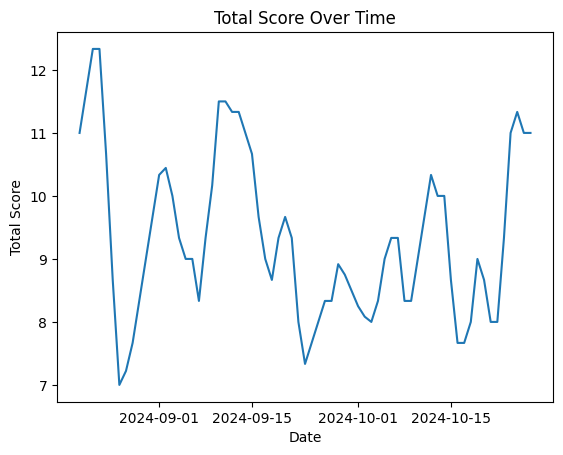

C:\Users\JakeSelvey\AppData\Local\Temp\ipykernel_2156\1105561763.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekend_scores = raw_scores.groupby('weekend').mean()


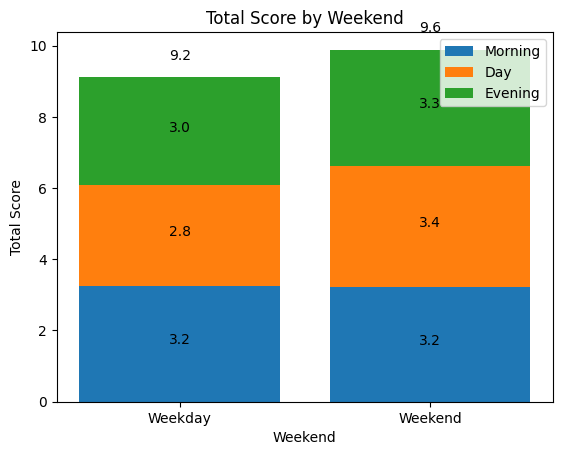

C:\Users\JakeSelvey\AppData\Local\Temp\ipykernel_2156\1105561763.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  day_scores = raw_scores.groupby('day_of_week').mean()


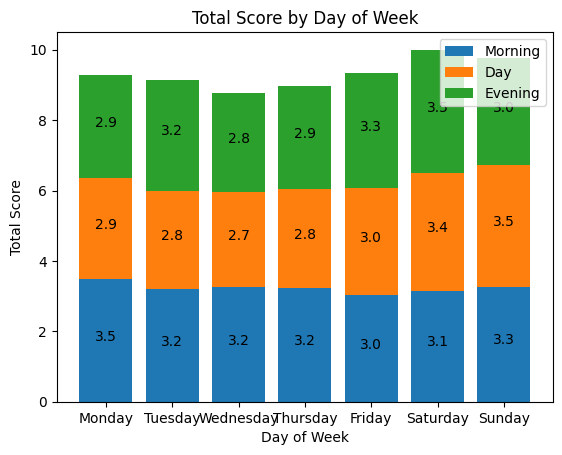

In [7]:
#chart total score over time.
plt.plot(raw_scores['habit_date'], raw_scores['total_score_chart_r3'])
plt.xlabel('Date')
plt.ylabel('Total Score')
plt.title('Total Score Over Time')
plt.show()

#chart total score by week using bar chart
# weekly_scores = raw_scores.groupby('week_number').mean()
# plt.bar(weekly_scores.index, weekly_scores['total_score_chart_r3'])
# plt.xlabel('Week Number')
# plt.ylabel('Total Score')
# plt.title('Total Score by Week')


#create a stacked bar chart of morning_chart, day_chart, and evening_chart by the weekend column.  add value labels for each, but also the value for total_score_chart_3 on the top of each. X axis labels should only be 0 for weekday, 1 for weekend
weekend_scores = raw_scores.groupby('weekend').mean()
plt.bar(weekend_scores.index, weekend_scores['morning_chart'], label='Morning')
plt.bar(weekend_scores.index, weekend_scores['day_chart'], bottom=weekend_scores['morning_chart'], label='Day')
plt.bar(weekend_scores.index, weekend_scores['evening_chart'], bottom=weekend_scores['morning_chart'] + weekend_scores['day_chart'], label='Evening')
plt.xlabel('Weekend')
plt.ylabel('Total Score')
plt.title('Total Score by Weekend')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.legend()
for i, v in enumerate(weekend_scores['morning_chart']):
    plt.text(i, v/2, str(round(v, 1)), ha='center')
    plt.text(i, v + weekend_scores['day_chart'][i]/2, str(round(weekend_scores['day_chart'][i], 1)), ha='center')
    plt.text(i, v + weekend_scores['day_chart'][i] + weekend_scores['evening_chart'][i]/2, str(round(weekend_scores['evening_chart'][i], 1)), ha='center')
    plt.text(i, v + weekend_scores['day_chart'][i] + weekend_scores['evening_chart'][i] + 0.5, str(round(weekend_scores['total_score_chart_r3'][i], 1)), ha='center')
plt.show()


#do the same as above but by day of week instead of weekend
day_scores = raw_scores.groupby('day_of_week').mean()
plt.bar(day_scores.index, day_scores['morning_chart'], label='Morning')
plt.bar(day_scores.index, day_scores['day_chart'], bottom=day_scores['morning_chart'], label='Day')
plt.bar(day_scores.index, day_scores['evening_chart'], bottom=day_scores['morning_chart'] + day_scores['day_chart'], label='Evening')
plt.xlabel('Day of Week')
plt.ylabel('Total Score')
plt.title('Total Score by Day of Week')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.legend()
for i, v in enumerate(day_scores['morning_chart']):
    plt.text(i, v/2, str(round(v, 1)), ha='center')
    plt.text(i, v + day_scores['day_chart'][i]/2, str(round(day_scores['day_chart'][i], 1)), ha='center')
    plt.text(i, v + day_scores['day_chart'][i] + day_scores['evening_chart'][i]/2, str(round(day_scores['evening_chart'][i], 1)), ha='center')
plt.show()


In [8]:
#correlation matrix for all columns. round to 2 decimal places
correlation_scores = raw_scores[['morning', 'day', 'evening', 'total_score', 'drinks', 'candy', 'pen', 'meditate', 'exercise'
                                 ,'meditate_lag1', 'exercise_lag1', 'drinks_lag1','drinks_flag_lag1', 'candy_lag1','candy_flag_lag1', 'pen_lag1','pen_flag_lag1'
                                 ,'morning_lag1','day_lag1','evening_lag1', 'total_score_lag1']].corr()
correlation_scores = correlation_scores.round(2)

#export to csv
correlation_scores.to_csv('correlation_scores.csv')

correlation_scores


,morning,day,evening,total_score,drinks,candy,pen,meditate,exercise,meditate_lag1,...,drinks_lag1,drinks_flag_lag1,candy_lag1,candy_flag_lag1,pen_lag1,pen_flag_lag1,morning_lag1,day_lag1,evening_lag1,total_score_lag1
morning,1.00,0.60,0.32,0.80,-0.42,-0.30,-0.02,0.23,0.34,-0.00,...,-0.30,-0.38,-0.10,-0.11,-0.08,0.05,0.41,0.26,0.06,0.29
day,0.60,1.00,0.53,0.88,-0.05,-0.02,-0.04,-0.09,0.06,0.01,...,-0.12,-0.13,-0.06,-0.02,-0.10,-0.02,0.45,0.37,0.22,0.40
evening,0.32,0.53,1.00,0.74,0.04,0.13,-0.11,0.05,0.07,-0.05,...,-0.06,0.02,-0.01,0.01,-0.01,-0.05,0.40,0.46,0.36,0.50
total_score,0.80,0.88,0.74,1.00,-0.18,-0.08,-0.06,0.10,0.17,-0.05,...,-0.19,-0.20,-0.07,-0.04,-0.08,0.00,0.51,0.43,0.25,0.46
drinks,-0.42,-0.05,0.04,-0.18,1.00,0.53,0.31,-0.20,-0.04,-0.19,...,0.40,0.57,0.49,0.55,0.21,0.10,-0.22,0.08,0.15,-0.01
candy,-0.30,-0.02,0.13,-0.08,0.53,1.00,-0.06,-0.11,-0.15,-0.00,...,0.39,0.42,0.43,0.40,0.40,0.22,-0.03,0.06,0.03,0.04
pen,-0.02,-0.04,-0.11,-0.06,0.31,-0.06,1.00,-0.16,0.01,-0.13,...,0.26,0.27,0.36,0.48,-0.02,0.04,-0.26,-0.04,-0.00,-0.15
meditate,0.23,-0.09,0.05,0.10,-0.20,-0.11,-0.16,1.00,0.34,0.06,...,-0.21,-0.19,-0.06,-0.11,0.08,-0.05,0.11,-0.09,0.12,0.07
exercise,0.34,0.06,0.07,0.17,-0.04,-0.15,0.01,0.34,1.00,0.11,...,0.03,0.05,0.13,0.09,-0.07,-0.03,0.11,0.11,0.12,0.16
meditate_lag1,-0.00,0.01,-0.05,-0.05,-0.19,-0.00,-0.13,0.06,0.11,1.00,...,-0.21,-0.26,-0.11,-0.11,-0.17,-0.15,0.23,-0.09,0.05,0.10


In [9]:
def print_regression_summary(X, y, model=None, feature_names=None):
    """
    Prints a detailed regression summary similar to R/Stata output
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Training data
    y : array-like of shape (n_samples,)
        Target values
    model : fitted sklearn model, optional
        If None, creates new LinearRegression
    feature_names : list-like, optional
        Names of features. If None, uses X.columns if available
    """
    if model is None:
        model = LinearRegression()
        model.fit(X, y)
    
    # Get feature names
    if feature_names is None:
        feature_names = getattr(X, 'columns', [f'X{i}' for i in range(X.shape[1])])
    
    # Calculate standard errors and t-statistics
    n = X.shape[0]
    p = X.shape[1]
    
    # Calculate residuals and MSE
    y_pred = model.predict(X)
    residuals = y - y_pred
    mse = np.sum(residuals**2) / (n - p - 1)
    
    # Calculate variance-covariance matrix
    X_array = np.array(X)
    var_covar_matrix = mse * np.linalg.inv(X_array.T.dot(X_array))
    
    # Standard errors are sqrt of diagonal elements
    std_errors = np.sqrt(np.diag(var_covar_matrix))
    
    # Calculate t-statistics and p-values
    t_stats = model.coef_ / std_errors
    p_values = 2 * (1 - stats.t.cdf(abs(t_stats), n - p - 1))
    
    # Calculate R-squared and adjusted R-squared
    r2 = model.score(X, y)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # Calculate F-statistic
    f_stat = (r2 / p) / ((1 - r2) / (n - p - 1))
    f_p_value = 1 - stats.f.cdf(f_stat, p, n - p - 1)
    
    # Print summary
    print('='*80)
    print('                              Regression Results                              ')
    print('='*80)
    print(f'Number of Observations:     {n}')
    print(f'Degrees of Freedom:         {n - p - 1}')
    print(f'R-squared:                  {r2:.4f}')
    print(f'Adjusted R-squared:         {adj_r2:.4f}')
    print(f'F-statistic:               {f_stat:.4f}')
    print(f'Prob (F-statistic):        {f_p_value:.4f}')
    print('-'*80)
    print('                    coef    std err    t-stat    P>|t|    [95% Conf. Int.]')
    print('-'*80)
    
    # Print coefficient table
    for i, name in enumerate(feature_names):
        conf_int = stats.t.interval(0.95, n - p - 1, 
                                  loc=model.coef_[i], 
                                  scale=std_errors[i])
        print(f'{name[:20]:20} {model.coef_[i]:>9.4f} {std_errors[i]:>10.4f} ',
              f'{t_stats[i]:>9.4f} {p_values[i]:>9.4f} ',
              f'[{conf_int[0]:>7.4f}, {conf_int[1]:>7.4f}]')
    
    # Print intercept
    if hasattr(model, 'intercept_'):
        print('-'*80)
        print(f'Intercept: {model.intercept_:.4f}')
    print('='*80)
    
    return {
        'r2': r2,
        'adj_r2': adj_r2,
        'f_stat': f_stat,
        'f_p_value': f_p_value,
        'coefficients': model.coef_,
        'std_errors': std_errors,
        't_stats': t_stats,
        'p_values': p_values
    }

In [25]:
#do a stepwise regression to predict total_score based on all other columns.  Do not split into training and testing data. Remove reords where any x or y is null
raw_scores = raw_scores.dropna(subset=['morning', 'day', 'evening', 'total_score', 'drinks', 'candy', 'pen', 'meditate', 'exercise'
                                 ,'meditate_lag1', 'exercise_lag1', 'drinks_lag1','drinks_flag_lag1', 'candy_lag1','candy_flag_lag1', 'pen_lag1','pen_flag_lag1'
                                 ,'morning_lag1','day_lag1','evening_lag1', 'total_score_lag1'])

#create squared values for drinks_lag1, candy_lag1, and pen_lag1
raw_scores['drinks_lag1_sq'] = raw_scores['drinks_lag1']**2
raw_scores['candy_lag1_sq'] = raw_scores['candy_lag1']**2
raw_scores['pen_lag1_sq'] = raw_scores['pen_lag1']**2

# X = raw_scores[['meditate', 'exercise','weekend'
#                 ,'meditate_lag1', 'exercise_lag1', 'drinks_lag1','drinks_flag_lag1', 'candy_lag1','candy_flag_lag1', 'pen_lag1','pen_flag_lag1'
#                 ,'morning_lag1','day_lag1','evening_lag1', 'total_score_lag1'
#                 ,'drinks_lag1_sq','candy_lag1_sq','pen_lag1_sq']]


#### use lag levels
# X = raw_scores[[  'meditate', 'exercise','weekend'
#                 ,'meditate_lag1', 'exercise_lag1', 'drinks_lag1','candy_lag1','pen_lag1'
#                 ,'morning_lag1','day_lag1','evening_lag1']]

#### use lag flags
# X = raw_scores[[  'meditate', 'exercise','weekend'
#                 ,'meditate_lag1', 'exercise_lag1', 'drinks_flag_lag1','candy_flag_lag1','pen_flag_lag1'
#                 ,'morning_lag1','day_lag1','evening_lag1']]

#### use lag levels and squared values
# X = raw_scores[[  'meditate', 'exercise','weekend'
#                 ,'meditate_lag1', 'exercise_lag1', 'drinks_lag1','candy_lag1','pen_lag1'
#                 ,'morning_lag1','day_lag1','evening_lag1'
#                 ,'drinks_lag1_sq','candy_lag1_sq','pen_lag1_sq']]


#all but remove flags
X = raw_scores[['weekend'
                ,'meditate_lag1', 'exercise_lag1', 'drinks_lag1', 'candy_lag1', 'pen_lag1'
                ,'morning_lag1','day_lag1','evening_lag1'
                ,'drinks_lag1_sq','candy_lag1_sq','pen_lag1_sq']]

y = raw_scores['total_score']

#provide summary of the model, including coefficients and intercept
model = LinearRegression()
rfe = RFE(model)
fit = rfe.fit(X, y)

# Get selected features
selected_features = X.columns[fit.support_]
X_selected = X[selected_features]

# Fit final model and print summary
model.fit(X_selected, y)
summary = print_regression_summary(X_selected, y, model, feature_names=selected_features)


                              Regression Results                              
Number of Observations:     48
Degrees of Freedom:         46
R-squared:                  0.0030
Adjusted R-squared:         -0.0187
F-statistic:               0.1385
Prob (F-statistic):        0.7115
--------------------------------------------------------------------------------
                    coef    std err    t-stat    P>|t|    [95% Conf. Int.]
--------------------------------------------------------------------------------
candy_lag1_sq          -0.3056     0.7602    -0.4019    0.6896  [-1.8357,  1.2246]
--------------------------------------------------------------------------------
Intercept: 9.1840
